In [ ]:
#BLOG: https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093

In [ ]:
#GitHub: https://github.com/statisticianinstilettos/recmetrics

# RecMetrics Example

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 4.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... \

In [4]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 25.2 MB/s eta 0:00:0000:0100:01


In [6]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.5 MB/s eta 0:00:00a 0:00:01


In [8]:
!pip install funcsigs

In [ ]:
!pip install recmetrics

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
import recmetrics

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data [here](https://grouplens.org/datasets/movielens/20m/).

In [2]:
ratings = pd.read_csv('./ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=1000
users = ratings["userId"].value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print(ratings.shape)
ratings.head(3)

(1317902, 4)


,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803


## Get movie features

In [6]:
rated_movies = ratings["movieId"].tolist()

movies = pd.read_csv('./ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies["genres"].str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

movies.drop_duplicates("movieId", inplace=True)
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

The Long Tail plot is used to explore popularity patterns in user-item interaction data. Typically, a small number of items will make up most of the volume of interactions and this is referred to as the "head". The "long tail" typically consists of most products, but make up a small percent of interaction volume.

In [7]:
ratings

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117
...,...,...,...,...
16469170,138325,93865,4.5,1352441167
16469171,138325,94896,4.0,1350349645
16469172,138325,96610,4.5,1350342435
16469173,138325,96737,4.5,1350342507


/Users/chirag/opt/miniconda3/envs/py38x64/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/chirag/opt/miniconda3/envs/py38x64/lib/python3.8/site-packages/recmetrics/plots.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  head = head.append(tail.head(1))


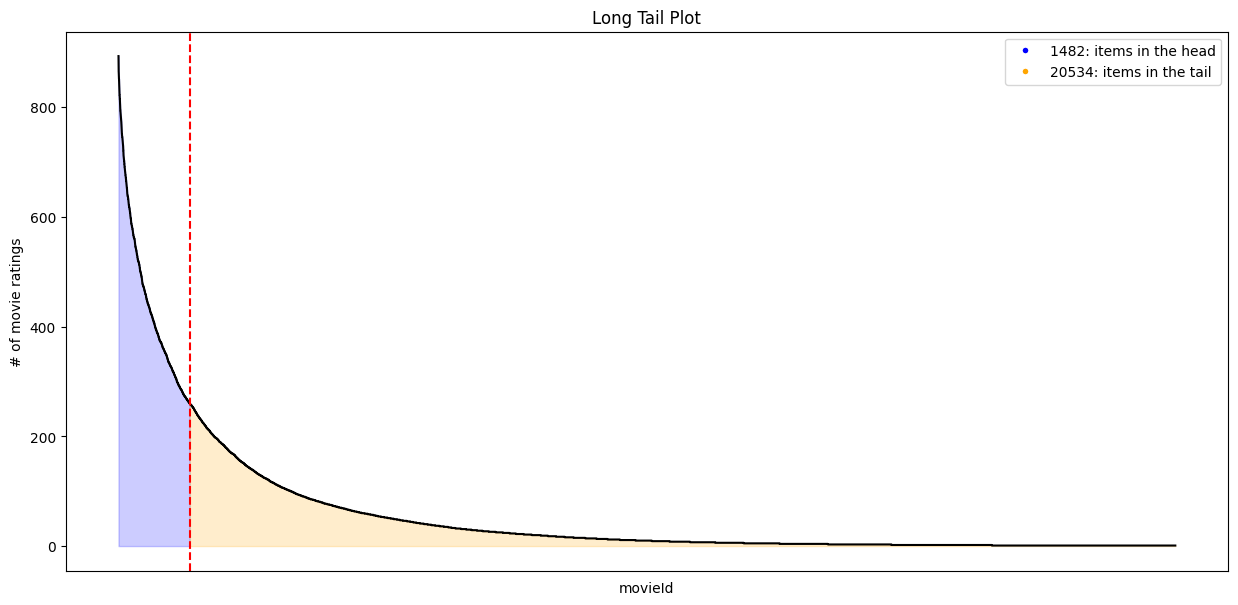

In [8]:
fig = plt.figure(figsize=(15, 7))

recmetrics.long_tail_plot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

The items in the "long tail" usually do not have enough interactions to accurately be recommended using user-based recommender systems like collaborative filtering due to inherent popularity bias in these models and data sparsity. Many recommender systems require a certain level of sparsity to train. A good recommender must balance sparsity requirements with popularity bias.

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. I've implemented collaborative filtering using a SVD approach in the surprise package. The surprise package also takes care of the test train split. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

## Format data for Surprise

In [9]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

## Train SVD Recommender

In [10]:
algo = SVD()
algo.fit(trainset)

## Make predictions on SVD test set

In [11]:
test = algo.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['userId', 'movieId', 'actual', 'cf_predictions']
test.head()

,userId,movieId,actual,cf_predictions
0,61168,103341,4.0,3.509382
1,16676,90266,4.5,3.811754
2,125794,4037,5.0,4.196935
3,61053,1199,4.5,4.112337
4,137277,58652,3.0,3.253855


## Evaluate model with MSE and RMSE

In [12]:
test.actual, test.cf_predictions

(0         4.0
 1         4.5
 2         5.0
 3         4.5
 4         3.0
          ... 
 329471    4.5
 329472    3.0
 329473    4.5
 329474    4.0
 329475    4.0
 Name: actual, Length: 329476, dtype: float64,
 0         3.509382
 1         3.811754
 2         4.196935
 3         4.112337
 4         3.253855
             ...   
 329471    4.267611
 329472    3.281042
 329473    3.973436
 329474    3.519543
 329475    3.575604
 Name: cf_predictions, Length: 329476, dtype: float64)

In [13]:
print("MSE: ", recmetrics.mse(test.actual, test.cf_predictions))
print("RMSE: ", recmetrics.rmse(test.actual, test.cf_predictions))

MSE:  0.26678580692013226
RMSE:  0.5165131236668942


In [14]:
#create model (matrix of predicted values)
cf_model = test.pivot_table(index='userId', columns='movieId', values='cf_predictions').fillna(0)
cf_model

movieId,1,2,3,4,5,6,7,8,9,10,...,131112,131120,131134,131140,131150,131158,131174,131241,131243,131250
userId,,,,,,,,,,,,,,,,,,,,,
156,0.000000,0.0,0.0,0.0,3.535603,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,0.000000,0.0,0.0,0.0,0.000000,4.129964,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
394,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
572,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137277,0.000000,0.0,0.0,0.0,0.000000,3.855514,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137686,4.367531,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138208,3.511877,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [16]:
#get example prediction
get_users_predictions(156, 10, cf_model)

[110, 2028, 2571, 1610, 1097, 1214, 1961, 1221, 1302, 1527]

In [17]:
test

,userId,movieId,actual,cf_predictions
0,61168,103341,4.0,3.509382
1,16676,90266,4.5,3.811754
2,125794,4037,5.0,4.196935
3,61053,1199,4.5,4.112337
4,137277,58652,3.0,3.253855
...,...,...,...,...
329471,59852,50068,4.5,4.267611
329472,38539,3136,3.0,3.281042
329473,99342,2134,4.5,3.973436
329474,123327,5668,4.0,3.519543


In [18]:
test = test.copy().groupby('userId', as_index=False)['movieId'].agg({'actual': (lambda x: list(set(x)))})

In [19]:
test = test.set_index("userId")

In [20]:
test

,actual
userId,
156,"[5, 12, 2062, 17, 2067, 25, 4129, 35, 6184, 20..."
208,"[1537, 69122, 89090, 4103, 44555, 523, 3083, 1..."
359,"[33794, 2565, 45062, 6, 1032, 57353, 524, 5582..."
394,"[54272, 1537, 26116, 3077, 6663, 4617, 44555, ..."
572,"[54272, 2561, 54787, 39427, 2054, 69640, 520, ..."
...,...
137277,"[6, 100363, 2060, 18, 57368, 4135, 106540, 209..."
137686,"[1, 2058, 2059, 11, 6157, 2064, 8225, 42, 47, ..."
138208,"[1, 83976, 2058, 2059, 77837, 6157, 17, 57368,..."


In [21]:
#Each user would have a different length of "actual" 

In [22]:
minimum=len(test.iloc[0]['actual'])
maximum=len(test.iloc[0]['actual'])
    
for i,row in test.iterrows():
    #print(i)
    #print(len(row['actual']))
    #print()

    if(len(row['actual'])>=maximum):
        maximum=len(row['actual'])
    if(len(row['actual'])<=minimum):
        minimum=len(row['actual'])


print(minimum)
print(maximum)



224
2006


In [23]:
#min no of transactions by a user is 225
#max no of transactions by a user is 2077

In [24]:
test['no of interactions'] = test['actual'].str.len()

In [25]:
test

,actual,no of interactions
userId,,
156,"[5, 12, 2062, 17, 2067, 25, 4129, 35, 6184, 20...",509
208,"[1537, 69122, 89090, 4103, 44555, 523, 3083, 1...",289
359,"[33794, 2565, 45062, 6, 1032, 57353, 524, 5582...",271
394,"[54272, 1537, 26116, 3077, 6663, 4617, 44555, ...",294
572,"[54272, 2561, 54787, 39427, 2054, 69640, 520, ...",249
...,...,...
137277,"[6, 100363, 2060, 18, 57368, 4135, 106540, 209...",418
137686,"[1, 2058, 2059, 11, 6157, 2064, 8225, 42, 47, ...",459
138208,"[1, 83976, 2058, 2059, 77837, 6157, 17, 57368,...",343


In [26]:
test['no of interactions'].min(), test['no of interactions'].max()

(224, 2006)

In [27]:
# make recommendations for all members in the test data

cf_recs = [] = []
for user in test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
test['cf_predictions'] = cf_recs
test.head()

,actual,no of interactions,cf_predictions
userId,,,
156,"[5, 12, 2062, 17, 2067, 25, 4129, 35, 6184, 20...",509,"[110, 2028, 2571, 1610, 1097, 1214, 1961, 1221..."
208,"[1537, 69122, 89090, 4103, 44555, 523, 3083, 1...",289,"[858, 296, 593, 905, 1136, 1248, 903, 260, 732..."
359,"[33794, 2565, 45062, 6, 1032, 57353, 524, 5582...",271,"[1196, 593, 912, 3307, 953, 58559, 913, 48516,..."
394,"[54272, 1537, 26116, 3077, 6663, 4617, 44555, ...",294,"[922, 924, 5291, 1248, 912, 296, 6016, 3160, 1..."
572,"[54272, 2561, 54787, 39427, 2054, 69640, 520, ...",249,"[318, 7153, 1270, 5952, 589, 1704, 47, 1291, 5..."


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [28]:
#make recommendations for all members in the test data
popularity_recs = ratings.movieId.value_counts().head(10).index.tolist()
popularity_recs


[1198, 593, 1270, 2762, 318, 2571, 260, 1240, 296, 608]

In [29]:
pop_recs = []
for user in test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
test['pop_predictions'] = pop_recs
test.head()

,actual,no of interactions,cf_predictions,pop_predictions
userId,,,,
156,"[5, 12, 2062, 17, 2067, 25, 4129, 35, 6184, 20...",509,"[110, 2028, 2571, 1610, 1097, 1214, 1961, 1221...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ..."
208,"[1537, 69122, 89090, 4103, 44555, 523, 3083, 1...",289,"[858, 296, 593, 905, 1136, 1248, 903, 260, 732...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ..."
359,"[33794, 2565, 45062, 6, 1032, 57353, 524, 5582...",271,"[1196, 593, 912, 3307, 953, 58559, 913, 48516,...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ..."
394,"[54272, 1537, 26116, 3077, 6663, 4617, 44555, ...",294,"[922, 924, 5291, 1248, 912, 296, 6016, 3160, 1...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ..."
572,"[54272, 2561, 54787, 39427, 2054, 69640, 520, ...",249,"[318, 7153, 1270, 5952, 589, 1704, 47, 1291, 5...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ..."


# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [30]:
#make recommendations for all members in the test data

ran_recs = []
for user in test.index:
    random_predictions = ratings.movieId.sample(10).values.tolist()
    ran_recs.append(random_predictions)
        
test['random_predictions'] = ran_recs
test.head()

,actual,no of interactions,cf_predictions,pop_predictions,random_predictions
userId,,,,,
156,"[5, 12, 2062, 17, 2067, 25, 4129, 35, 6184, 20...",509,"[110, 2028, 2571, 1610, 1097, 1214, 1961, 1221...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ...","[5049, 4008, 1588, 64839, 4246, 1488, 920, 137..."
208,"[1537, 69122, 89090, 4103, 44555, 523, 3083, 1...",289,"[858, 296, 593, 905, 1136, 1248, 903, 260, 732...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ...","[4662, 2712, 44, 4995, 1730, 8528, 3753, 66371..."
359,"[33794, 2565, 45062, 6, 1032, 57353, 524, 5582...",271,"[1196, 593, 912, 3307, 953, 58559, 913, 48516,...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ...","[588, 87232, 25777, 1198, 8814, 1904, 3452, 12..."
394,"[54272, 1537, 26116, 3077, 6663, 4617, 44555, ...",294,"[922, 924, 5291, 1248, 912, 296, 6016, 3160, 1...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ...","[1639, 158, 224, 897, 6413, 6258, 2529, 1253, ..."
572,"[54272, 2561, 54787, 39427, 2054, 69640, 520, ...",249,"[318, 7153, 1270, 5952, 589, 1704, 47, 1291, 5...","[1198, 593, 1270, 2762, 318, 2571, 260, 1240, ...","[44195, 7347, 2020, 7153, 77820, 1668, 7102, 2..."


In [31]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [32]:
#As mentioned above, actual will have different no of items transacted for each user

In [33]:
len(cf_predictions), len(cf_predictions[0])

(933, 10)

In [34]:
len(pop_predictions), len(pop_predictions[0])

(933, 10)

In [35]:
len(random_predictions), len(random_predictions[0])

(933, 10)

 MAP@K gives insight into how relevant the list of recommended items are, whereas MAR@K gives insight into how well the recommender is able to recall all the items the user has rated positively in the test set

# Recall

Mean Average Recall at K (Mar@k) measures the recall at the kth recommendations. Mar@k considers the order of recommendations, and penalizes correct recommendations based on the order of the recommendations. Mar@k is ideal for evaluating an ordered list of recommendations. 

In [36]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([recmetrics.mark(actual, pop_predictions, k=K)])
pop_mark

[0.0007728899154068677,
 0.0012412620340722024,
 0.0015784317311706398,
 0.001898281393998366,
 0.002185191634296431,
 0.0024451633065336125,
 0.0026805795599480035,
 0.0029202516668994207,
 0.0031529387906027704,
 0.003377465663499973]

In [37]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([recmetrics.mark(actual, random_predictions, k=K)])
random_mark

[0.00021687353003470617,
 0.0003609319071576858,
 0.00046587039817210424,
 0.0005415091453677263,
 0.0005918072349670159,
 0.0006543113294611636,
 0.0007001845129771756,
 0.0007430951054912284,
 0.0007812688522579885,
 0.0008226355775863541]

In [38]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([recmetrics.mark(actual, cf_predictions, k=K)])
cf_mark

[0.0030798877853085386,
 0.006159775570617077,
 0.009239663355925614,
 0.012319551141234154,
 0.015399438926542693,
 0.018479326711851228,
 0.021559214497159772,
 0.02463910228246831,
 0.027718990067776846,
 0.030798877853085386]

# Mark Plot

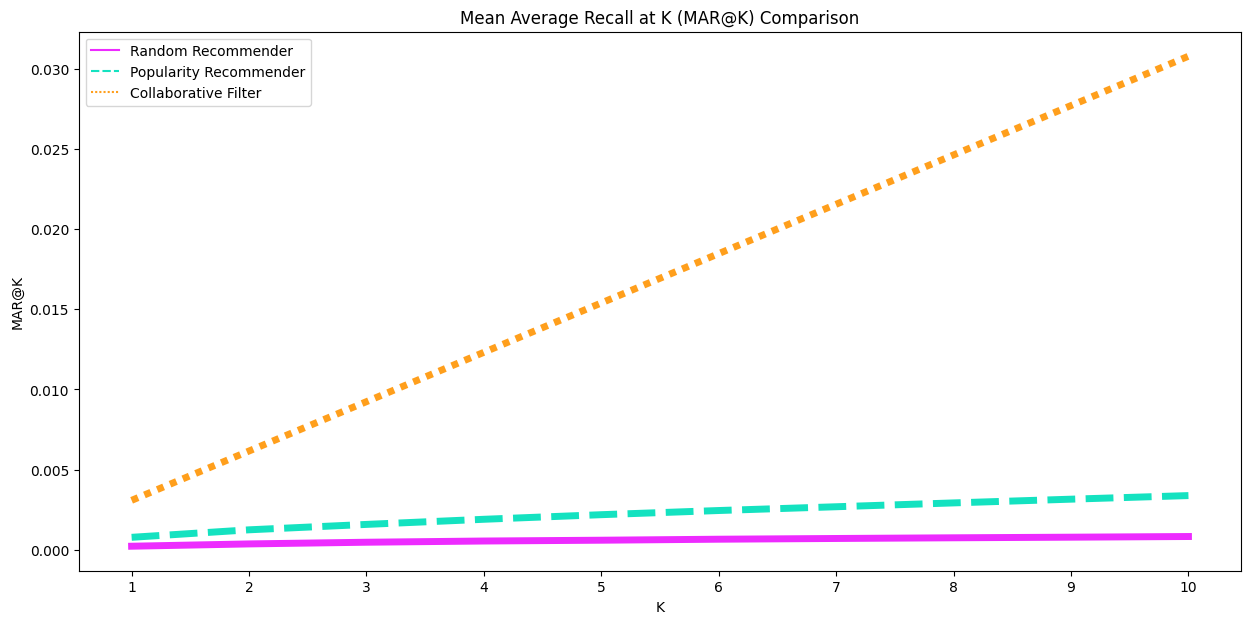

In [39]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

# Prediction Coverage

In [40]:
ratings

,userId,movieId,rating,timestamp
15918,156,1,5.0,1037739266
15919,156,2,5.0,1040937649
15920,156,4,3.0,1038801803
15921,156,5,3.0,1040944583
15922,156,6,4.0,1037822117
...,...,...,...,...
16469170,138325,93865,4.5,1352441167
16469171,138325,94896,4.0,1350349645
16469172,138325,96610,4.5,1350342435
16469173,138325,96737,4.5,1350342507


In [41]:
catalog = ratings.movieId.unique().tolist()

In [42]:
random_coverage = recmetrics.prediction_coverage(ran_recs, catalog)
pop_coverage = recmetrics.prediction_coverage(pop_recs, catalog)
cf_coverage = recmetrics.prediction_coverage(cf_recs, catalog)
random_coverage,pop_coverage,cf_coverage


(21.28, 0.05, 2.6)

# Catalog Coverage

In [43]:
# N=100 observed recommendation lists (The number of observed recommendation lists which randomly choosed in our offline setup)

random_cat_coverage = recmetrics.catalog_coverage(ran_recs, catalog, 100)
pop_cat_coverage = recmetrics.catalog_coverage(pop_recs, catalog, 100)
cf_cat_coverage = recmetrics.catalog_coverage(cf_recs, catalog, 100)

In [44]:
random_cat_coverage,pop_cat_coverage,cf_cat_coverage

(3.93, 0.05, 1.12)

# Coverage Plot

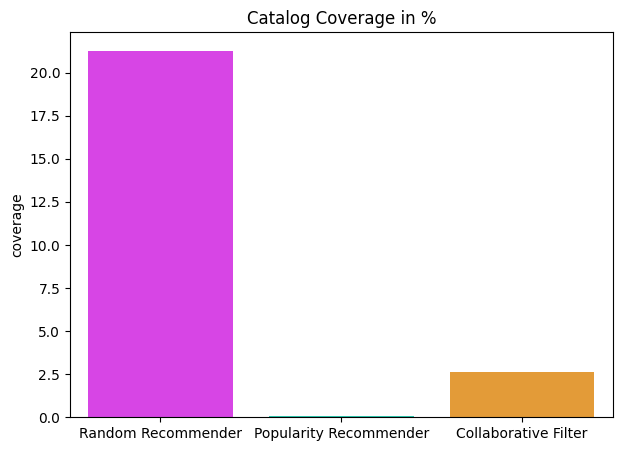

In [45]:
# plot of prediction coverage
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(coverage_scores, model_names)

# Novelty

In [46]:
nov = ratings.movieId.value_counts()
pop = dict(nov)
pop

{1198: 893,
 593: 876,
 1270: 876,
 2762: 867,
 318: 864,
 2571: 863,
 260: 859,
 1240: 857,
 296: 856,
 608: 853,
 1196: 851,
 1265: 851,
 50: 848,
 2858: 842,
 2716: 840,
 858: 838,
 1: 836,
 589: 835,
 4226: 832,
 4993: 831,
 1214: 828,
 457: 827,
 1036: 822,
 356: 822,
 1291: 821,
 480: 817,
 32: 815,
 1097: 815,
 1617: 814,
 1193: 814,
 1387: 809,
 541: 807,
 1704: 806,
 47: 805,
 1210: 801,
 2959: 798,
 1580: 797,
 1961: 795,
 1682: 794,
 2028: 794,
 1200: 793,
 3578: 792,
 592: 792,
 527: 789,
 5445: 788,
 4306: 787,
 2918: 787,
 919: 785,
 1213: 785,
 3996: 784,
 5349: 784,
 150: 783,
 5952: 781,
 1258: 779,
 2997: 778,
 1208: 777,
 5418: 776,
 2291: 774,
 1089: 774,
 1219: 772,
 1136: 770,
 1259: 769,
 377: 769,
 4963: 768,
 110: 762,
 2987: 759,
 2791: 759,
 912: 758,
 2797: 754,
 2174: 752,
 6539: 751,
 2115: 751,
 1221: 751,
 1784: 748,
 111: 747,
 1206: 747,
 4027: 746,
 1222: 746,
 1079: 746,
 7153: 746,
 2000: 745,
 1968: 745,
 3793: 744,
 5989: 742,
 1266: 741,
 4995: 7

In [47]:
random_novelty,random_mselfinfo_list = recmetrics.novelty(ran_recs, pop, len(users), 10)
pop_novelty,pop_mselfinfo_list = recmetrics.novelty(pop_recs, pop, len(users), 10)
cf_novelty,cf_mselfinfo_list = recmetrics.novelty(cf_recs, pop, len(users), 10)

In [48]:
print(random_novelty, pop_novelty, cf_novelty)

2.254136821466447 0.10697151566593387 0.6871566086310928


# Personalization

Personalization measures recommendation similarity across users. A high score indicates good personalization (user's lists of recommendations are different). A low score indicates poor personalization (user's lists of recommendations are very similar). A model is "personalizing" well if the set of recommendations for each user is different.

Personalization is a great way to assess if a model recommends many of the same items to different users. It is the dissimilarity (1- cosine similarity) between user’s lists of recommendations.

In [49]:
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'X']
]

In [50]:
recmetrics.personalization(predicted=example_predictions)

0.9166666666666666

In [51]:
#Exactly same predictions. So Personalization will be 0
example_predictions = [
    ['1', '2', 'C', 'D'],
   ['1', '2', 'C', 'D'],
    ['1', '2', 'C', 'D']
]

In [52]:
recmetrics.personalization(predicted=example_predictions)

0.0

In [53]:
#No common predictions across users, hence personalization is 1
example_predictions = [
    ['1', '2', 'C', 'D'],
    ['4', '3', 'm', 'X'],
    ['7', 'B', 't', 'Y']
]

In [54]:
recmetrics.personalization(predicted=example_predictions)

1.0

# Intra-list Similarity

Computes the average intra-list similarity of all recommendations. This metric can be used to measure diversity of the list of recommended items. 

Intra-list similarity is the average cosine similarity of all items in a list of recommendations. This calculation uses features of the recommended items (such as movie genre) to calculate the similarity.

Intra-list similarity can be calculated for each user, and averaged over all users in the test set to get an estimate of intra-list similarity for the model.


If a recommender system is recommending lists of very similar items to single users (for example, a user receives only recommendations of romance movies), then the intra-list similarity will be high.

In [55]:
movies

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131248,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131250,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
131252,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [56]:
feature_df = movies[['Action', 'Comedy', 'Romance']]

In [57]:
example_predictions = [
    [3, 7, 5, 9],
    [9, 6, 12, 623],
    [7, 894, 6, 623]
]

In [58]:
recmetrics.intra_list_similarity(example_predictions, feature_df)

0.27777777777777773

# Classification Probability Plot

Plots the predicted class probabilities for multiple classes. Usefull for visualizing predicted interaction values such as 5 star ratings, where a "class" is a star rating, or visualizing predicted class probabilities for binary classification model or recommender system. The true class states are colored.

In [59]:
#make fake classification probability data
class_one_probs = np.random.normal(loc=.7, scale=0.1, size=1000)
class_zero_probs = np.random.normal(loc=.3, scale=0.1, size=1000)
actual = [1] * 1000
class_zero_actual = [0] * 1000
actual.extend(class_zero_actual)

pred_df = pd.DataFrame([np.concatenate((class_one_probs, class_zero_probs), axis=None), actual]).T
pred_df.columns = ["predicted", "truth"]
pred_df.head()

,predicted,truth
0,0.549165,1.0
1,0.632893,1.0
2,0.747577,1.0
3,0.660605,1.0
4,0.592903,1.0


/Users/chirag/opt/miniconda3/envs/py38x64/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/chirag/opt/miniconda3/envs/py38x64/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


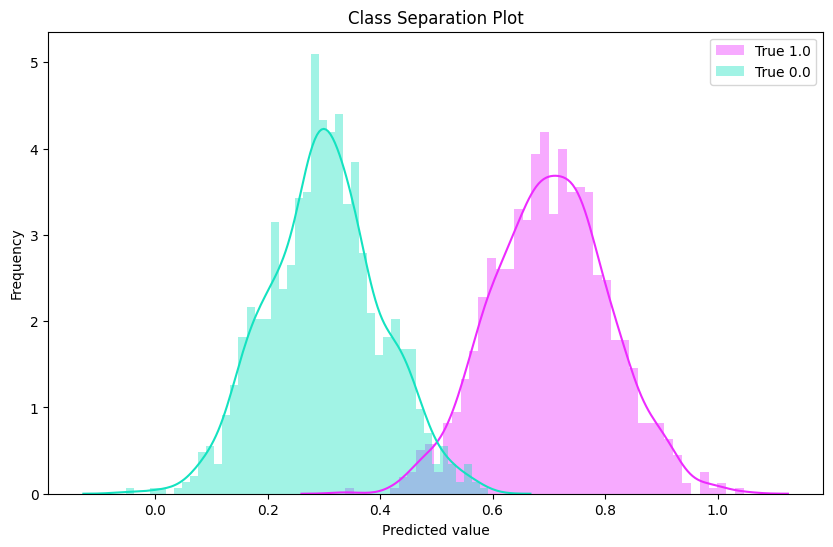

In [60]:
recmetrics.class_separation_plot(pred_df, n_bins=45, title="Class Separation Plot")

# ROC Plot

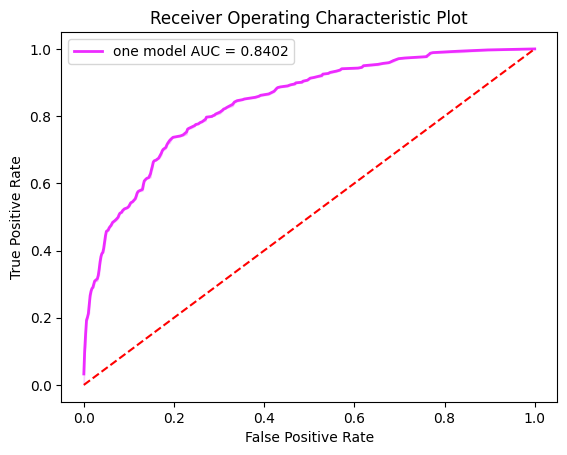

In [61]:
model_probs = np.concatenate([np.random.normal(loc=.2, scale=0.5, size=500), np.random.normal(loc=.9, scale=0.5, size=500)])
actual = [0] * 500
class_zero_actual = [1] * 500
actual.extend(class_zero_actual)

recmetrics.roc_plot(actual, model_probs, model_names="one model",  figsize=(10, 5))

# Precision Recall Curve

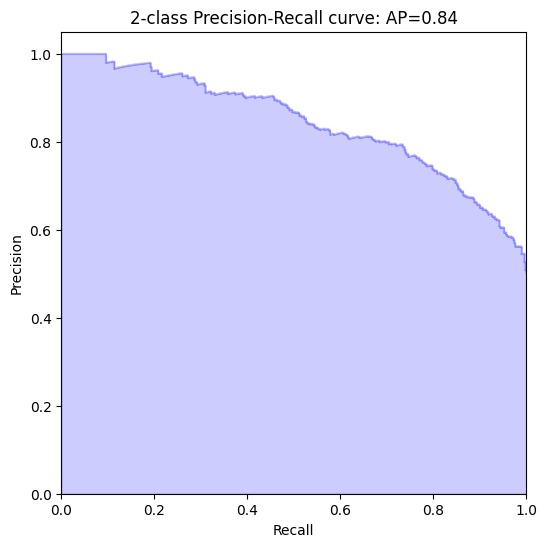

In [62]:
recmetrics.precision_recall_plot(targs=actual, preds=model_probs)

# Confusion Matrix

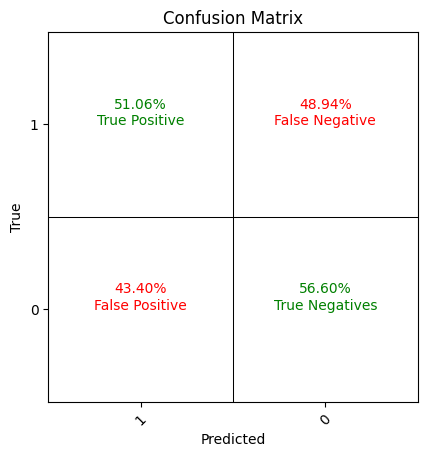

In [63]:
y_confusion_matrix = [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
                      0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
                      1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
                      1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
                      1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1]

yhat_confusion_matrix = [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
                         0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
                         1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
                         1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0,
                         1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1]


recmetrics.make_confusion_matrix(y=y_confusion_matrix, yhat=yhat_confusion_matrix)

## Create Metrics Plot

Plot the coverage, personalization, and intra-list similarity for a set of models to compare.

In [64]:
recmetrics.metrics_plot(model_names=['Model A', 'Model B', 'Model C'],
             coverage_scores=[0.17, 0.25, 0.76],
             personalization_scores=[0.43, 0.23, 0.44],
             intra_list_similarity_scores = [0.23, 0.21, 0.69])

### Using the right training data

There are a few things that can be done to the training data that could quickly improve a recommender system.

1.Remove popular items from the training data. (This is appropriate in cases where users can discover these items on their own, and may not find these recommendations useful).

2.Scale item ratings by the user’s value, such as average transaction value. This can help a model learn to recommend items that lead to loyal or high-value customers.


### Conclusion
A great recommender system makes both relevant and useful recommendations. Using a combination of multiple evaluation metrics, we can start to assess the performance of a model by more than just relevancy. 